In [1]:
# !pip3 install git+https://github.com/facebookresearch/esm.git
# !pip3 install matplotlib pandas seaborn fair-esm 
# !curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593_reprs.tar.gz
# !tar -xzf P62593_reprs.tar.gz
# !curl -O https://dl.fbaipublicfiles.com/fair-esm/examples/P62593.fasta
# !pwd
# !ls

!pip3 install fair-esm[esmfold]
!pip3 install git+https://github.com/huggingface/transformers
!pip3 install scikit-learn
!pip3 install datasets evaluate
!pip3 install pynvml numba

  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-97h8x1l5
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-97h8x1l5
  Resolved https://github.com/huggingface/transformers to commit 61d3928bfb3029bceb5be3e68ca3d4bf8456758f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import random
from collections import Counter
from tqdm import tqdm

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
import esm

In [3]:
# # Load ESM-2 model
# model, alphabet = esm.pretrained.esm2_t36_3B_UR50D()
# batch_converter = alphabet.get_batch_converter()
# model.eval()  # disables dropout for deterministic results

In [4]:
# # Prepare data (first 2 sequences from ESMStructuralSplitDataset superfamily / 4)
# data = [
#     ("protein1", "MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG"),
#     ("protein2", "KALTARQQEVFDLIRDHISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
#     ("protein2 with mask","KALTARQQEVFDLIRD<mask>ISQTGMPPTRAEIAQRLGFRSPNAAEEHLKALARKGVIEIVSGASRGIRLLQEE"),
#     ("protein3",  "K A <mask> I S Q"),
# ]
# batch_labels, batch_strs, batch_tokens = batch_converter(data)

# # Extract per-residue representations (on CPU)
# with torch.no_grad():
#     results = model(batch_tokens, repr_layers=[33], return_contacts=True)
# token_representations = results["representations"][33]

# # Generate per-sequence representations via averaging
# # NOTE: token 0 is always a beginning-of-sequence token, so the first residue is token 1.
# sequence_representations = []
# for i, (_, seq) in enumerate(data):
#     sequence_representations.append(token_representations[i, 1 : len(seq) + 1].mean(0))

# # Look at the unsupervised self-attention map contact predictions
# import matplotlib.pyplot as plt
# for (_, seq), attention_contacts in zip(data, results["contacts"]):
#     plt.matshow(attention_contacts[: len(seq), : len(seq)])
#     plt.title(seq)
#     plt.show()

In [3]:
import torch

torch.cuda.is_available(), torch.cuda.device_count(), torch.cuda.current_device(), torch.cuda.device(0), torch.cuda.get_device_name(0)

(True, 1, 0, <torch.cuda.device at 0x7feee47c8be0>, 'NVIDIA RTX A4000')

In [4]:
from pynvml import *


def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

from numba import cuda 
device = cuda.get_current_device()
device.reset()


In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
print_gpu_utilization()

GPU memory occupied: 261 MB.


In [7]:
import csv
csvfilepath = "./train.csv"

X_train = []
y_train = []

with open(csvfilepath) as csvfile:
    csvreader = csv.reader(csvfile)
    for row in csvreader:
        #print(row)
        if '1' not in row and '0' not in row:
            X_train.append(row[0])
        elif '1' in row:
            y_train.append(1)
        elif '0' in row:
            y_train.append(0)
        else:
            pass

In [8]:
X_train[0], len(X_train[0])

('SNAMKFSEFRYERPDIAQLQASFQEALDSFRRAGSAALQHEAMKRINELRRRYSTMANLCHIRHTIDTNDEFYKKEQDFFDETEPVVKGLVNDYYRALVSSPFRAELEQVWGKQLFALAETQLKTYAPVIVEDLQKENKLASEYTKLIASAKIMFEGEERTLAQLQPFVESPDRAMRQRASEARFSFFKDYEKELDELYDELVHVRTAIARKLGFQNFVELGYARLGRTDYNADMVAGYRRQVKTHIVPLAAKLRERQRQRIQVEKLYYYDEPFMFPTGNPTPKGDADWIVQNGRQMYEELSPETGEFFRYMVEHELMDLVAKKGKAGGGYCTYIDDYKAPFIFSNFTGTSGDIDVLTHEAGHAFQVYESRHYDIPEYNWPTLEACEIHSMSMEFFTWPWMELFFGEDADKYRFAHLSDALLFLPYGVAVDEFQHAVYENPDMTPAERKSVWRNIEKAYLPTRDYADHDYLERGGFWQRQGHIYTDPFYYIDYTLAQVCAFQFWKRAQEDRASAWRDYVALCRLGGSRPFTELVKSANLQSPFADGAVASVVGHIERWLDSVDDKAL',
 567)

In [9]:
y_train[0]

1

In [10]:
len(X_train), len(y_train)

(26821, 26821)

In [11]:
import torch 
import torch.nn as nn
from transformers import EsmTokenizer, EsmForSequenceClassification

In [58]:
# class CustomESMCrystalModel(nn.Module):
#     def __init__(self,num_labels): 
#         super(CustomESMCrystalModel,self).__init__() 
#         self.num_labels = num_labels 

#         #Load Model with given checkpoint and extract its body
#         self.model = EsmForSequenceClassification.from_pretrained("facebook/esm2_t6_8M_UR50D", num_labels=768, output_attentions=True, output_hidden_states=True)
#         self.dropout = nn.Dropout(0.1) 
#         self.classifier = nn.Linear(768,num_labels) # load and initialize weights
    
#     def forward(self, input_ids=None, attention_mask=None,labels=None):
#         #Extract outputs from the body
#         outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

#         #Add custom layers
#         # outputs has the following shape: (batch_size, sequence_length, 768)

#         #sequence_output = self.dropout(outputs[0]) #outputs[0]=last hidden state

#         logits = self.classifier(outputs[0,0,:].view(-1,768)) # calculate losses

#         loss = None
#         if labels is not None:
#             loss_fct = nn.CrossEntropyLoss()
#             loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
    
#         return SequenceClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)

In [12]:
tokenizer = EsmTokenizer.from_pretrained("facebook/esm2_t12_35M_UR50D")
model = EsmForSequenceClassification.from_pretrained("facebook/esm2_t12_35M_UR50D", num_labels=2).to(device)

Some weights of the model checkpoint at facebook/esm2_t12_35M_UR50D were not used when initializing EsmForSequenceClassification: ['lm_head.dense.weight', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t12_35M_UR50D and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.bias', 'classifier.out_proj.weight', 

In [13]:
from datasets import Dataset 
from torch.utils.data import DataLoader

ds = Dataset.from_dict({ 
                        "input_ids": tokenizer(X_train, padding=True,  # Pad to max_length
                                              truncation=True,
                              return_tensors='pt').to(device)["input_ids"],
                        "attention_mask": tokenizer(X_train, padding=True,  # Pad to max_length
                                              truncation=True,
                              return_tensors='pt').to(device)["attention_mask"],
                        "label": y_train}, split="train").with_format("torch")
#ds_split = ds.train_test_split(test_size=0.3)

In [14]:
ds[1]['attention_mask'].shape

torch.Size([1024])

In [15]:
print_gpu_utilization()


GPU memory occupied: 1852 MB.


In [22]:
#tokenizer(ds[1]["data"], return_tensors="pt")#["input_ids"].shape

In [ ]:
#ds[1]['data']

In [31]:
#encoded_dataset = ds.map(lambda ex: tokenizer(ex['data'], padding='max_length',  # Pad to max_length
#                                              truncation=True,
#                              return_tensors='pt'), batched=True, batch_size=8)

In [16]:
ds_split = ds.shuffle(seed=41).train_test_split(test_size=0.05)

In [17]:
ds_split

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 25479
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'label'],
        num_rows: 1342
    })
})

In [18]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="steps", 
                                  per_device_train_batch_size=8, per_device_eval_batch_size=8,
                                 logging_first_step=True, logging_steps = 1, num_train_epochs=7,
                                 resume_from_checkpoint=True, save_steps=2000, save_total_limit=10,
                                 gradient_accumulation_steps=4,
                                 load_best_model_at_end=True, metric_for_best_model="accuracy",
                                 save_strategy="steps", eval_steps=500)

import numpy as np
import evaluate
from sklearn.metrics import accuracy_score

#metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metrics.compute(references=labels, predictions=predictions)

    # {
    #         "accuracy": float(
    #             accuracy_score(references=labels, predictions=predictions)
    #         )
    #     }


#inputs = tokenizer("MKTVRQERLKSIVRILERSKEPVSGAQLAEELSVSRQVIVQDIAYLRSLGYNIVATPRGYVLAGG", return_tensors="pt")


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_split["train"],
    eval_dataset=ds_split["test"],
    compute_metrics=compute_metrics,
)

# with torch.no_grad():
#     logits = model(**inputs).logits

# predicted_class_id = logits.argmax().item()
# model.config.id2label[predicted_class_id]


In [19]:
ds_split["train"]['input_ids'].size()

torch.Size([25479, 1024])

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 25479
  Num Epochs = 7
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 4
  Total optimization steps = 5572
  Number of trainable parameters = 33993602


In [28]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |     775 MB |    2487 MB |  708093 GB |  708092 GB |\n|       from large pool |     512 MB |    2224 MB |  694548 GB |  694547 GB |\n|       from small pool |     262 MB |     264 MB |   13545 GB |   13545 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |     775 MB |    2487 MB |  708093 GB |  708092 GB |\n|       from large pool |     512 MB |    2224 MB |

In [29]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1342
  Batch size = 1


{'eval_loss': 0.4808196425437927,
 'eval_accuracy': 0.8956780923994039,
 'eval_runtime': 137.0744,
 'eval_samples_per_second': 9.79,
 'eval_steps_per_second': 9.79,
 'epoch': 3.0}

In [31]:
import csv
testcsvfilepath = "./test.csv"

X_test = []
y_test = []

with open(testcsvfilepath) as testcsvfile:
    csvreader = csv.reader(testcsvfile)
    for row in csvreader:
        #print(row)
        if '1' not in row and '0' not in row:
            X_test.append(row[0])
        elif '1' in row:
            y_test.append(1)
        elif '0' in row:
            y_test.append(0)
        else:
            pass

In [32]:
len(X_test), len(y_test)

(1898, 1898)

In [33]:
test_ds = Dataset.from_dict({ 
                        "input_ids": tokenizer(X_test, padding=True,  # Pad to max_length
                                              truncation=True,
                              return_tensors='pt').to(device)["input_ids"],
                        "attention_mask": tokenizer(X_test, padding=True,  # Pad to max_length
                                              truncation=True,
                              return_tensors='pt').to(device)["attention_mask"],
                        "label": y_test}, split="test").with_format("torch")

In [ ]:
# encoded_test_dataset = test_ds.map(lambda ex: tokenizer(ex['data'], padding='max_length',  # Pad to max_length
#                                               truncation=True,
#                               return_tensors='pt'), batched=True, batch_size=64)

In [34]:
test_ds

Dataset({
    features: ['input_ids', 'attention_mask', 'label'],
    num_rows: 1898
})

In [72]:
predictions = trainer.predict(test_ds)
print(predictions.predictions.shape, predictions.label_ids.shape)

***** Running Prediction *****
  Num examples = 1898
  Batch size = 1


(1898, 2) (1898,)


In [79]:
def softmax(x, axis=None):
    x = x - x.max(axis=axis, keepdims=True)
    y = np.exp(x)
    return y / y.sum(axis=axis, keepdims=True)

In [82]:
predictions.predictions

array([[-2.2164035,  2.563882 ],
       [ 2.5647802, -2.9282844],
       [-2.463273 ,  2.861759 ],
       ...,
       [ 3.3143802, -3.8342342],
       [ 2.5462682, -2.9016144],
       [ 3.7110417, -4.2077055]], dtype=float32)

In [88]:
#m = nn.Softmax(dim=-1)
#predictions_proba = m(predictions.predictions)
predictions_probs = softmax(predictions.predictions, axis=-1)
predictions_proba = [i[1] for i in softmax(predictions.predictions, axis=-1)]

In [38]:
import numpy as np

preds = np.argmax(predictions.predictions, axis=-1)

In [39]:
metric.compute(predictions=preds, references=predictions.label_ids)

{'accuracy': 0.8018967334035827}

In [40]:
trainer.save_model()

Saving model checkpoint to test_trainer
Configuration saved in test_trainer/config.json
Model weights saved in test_trainer/pytorch_model.bin


In [ ]:
#output = 

#trainer.predict(tokenizer(ds[1]["data"], return_tensors="pt"))

In [ ]:
#model = EsmForSequenceClassification.from_pretrained("test_trainer/checkpoint-500/")

In [ ]:
model.config

In [42]:
model_inputs = tokenizer("SNAMKFSEFRYERPDIAQLQASFQEALDSFRRAGSAALQHEAMKRINELRRRYSTMANLCHIRHTIDTNDEFYKKEQDFFDETEPVVKGLVNDYYRALVSSPFRAELEQVWGKQLFALAETQLKTYAPVIVEDLQKENKLASEYTKLIASAKIMFEGEERTLAQLQPFVESPDRAMRQRASEARFSFFKDYEKELDELYDELVHVRTAIARKLGFQNFVELGYARLGRTDYNADMVAGYRRQVKTHIVPLAAKLRERQRQRIQVEKLYYYDEPFMFPTGNPTPKGDADWIVQNGRQMYEELSPETGEFFRYMVEHELMDLVAKKGKAGGGYCTYIDDYKAPFIFSNFTGTSGDIDVLTHEAGHAFQVYESRHYDIPEYNWPTLEACEIHSMSMEFFTWPWMELFFGEDADKYRFAHLSDALLFLPYGVAVDEFQHAVYENPDMTPAERKSVWRNIEKAYLPTRDYADHDYLERGGFWQRQGHIYTDPFYYIDYTLAQVCAFQFWKRAQEDRASAWRDYVALCRLGGSRPFTELVKSANLQSPFADGAVASVVGHIERWLDSVDDKAL", 
    padding=True,  # Pad to max_length
    truncation=True,
    return_tensors='pt').to(device)
logits = model(**model_inputs)
probabilities = torch.nn.functional.softmax(logits.logits, dim=-1)
predictions = torch.argmax(probabilities, axis=1)

In [69]:
probabilities[0][1].item()

0.9985633492469788

In [48]:
test_ds

Dataset({
    features: ['input_ids', 'attention_mask', 'label'],
    num_rows: 1898
})

In [56]:
preds

array([1, 0, 1, ..., 0, 0, 0])

In [62]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
target_names = ['non-crystallizable', 'crystallizable']

In [58]:
print(classification_report(y_test, preds, target_names=target_names))

                    precision    recall  f1-score   support

non-crystallizable       0.73      0.98      0.84      1000
    crystallizable       0.96      0.60      0.74       898

          accuracy                           0.80      1898
         macro avg       0.85      0.79      0.79      1898
      weighted avg       0.84      0.80      0.79      1898



In [61]:
print(confusion_matrix(y_test, preds))

[[979  21]
 [355 543]]


In [87]:
print(roc_auc_score(y_test, predictions_proba))

0.9569543429844098


In [94]:
from sklearn.metrics import roc_curve, auc
n_classes = 2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test, predictions_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test, predictions_proba)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

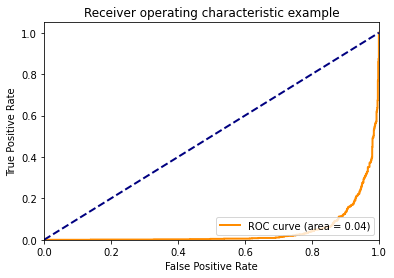

In [97]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(
    fpr[0],
    tpr[0],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[0],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

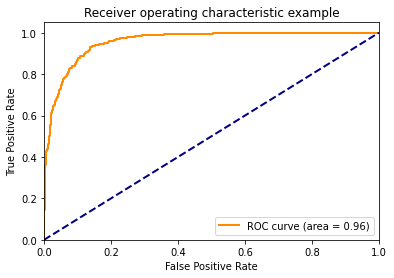

In [98]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(
    fpr[1],
    tpr[1],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[1],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

In [100]:
metric.compute(predictions=preds, references=predictions.label_ids)

{'accuracy': 0.8018967334035827}

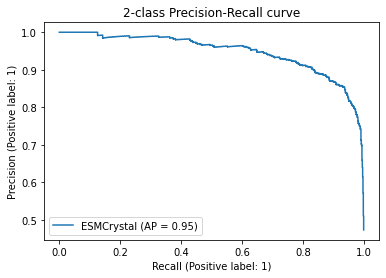

In [107]:
from sklearn.metrics import PrecisionRecallDisplay
display = PrecisionRecallDisplay.from_predictions(y_test, predictions_proba, name="ESMCrystal")
_ = display.ax_.set_title("2-class Precision-Recall curve")

In [110]:
from sklearn.metrics import matthews_corrcoef
matthews_corrcoef(y_test, preds)

0.6376660956611664

In [111]:
cm = confusion_matrix(y_test, preds)

In [112]:
[[tp, fp], [fn, tn]] = cm

In [114]:
tp, fp, fn, tn

(979, 21, 355, 543)

In [116]:
ppv = tp/(tp+fp)
ppv

0.979

In [117]:
npv = tn/(tn+fn)
npv

0.6046770601336303